# Part (2): Image Mosaics

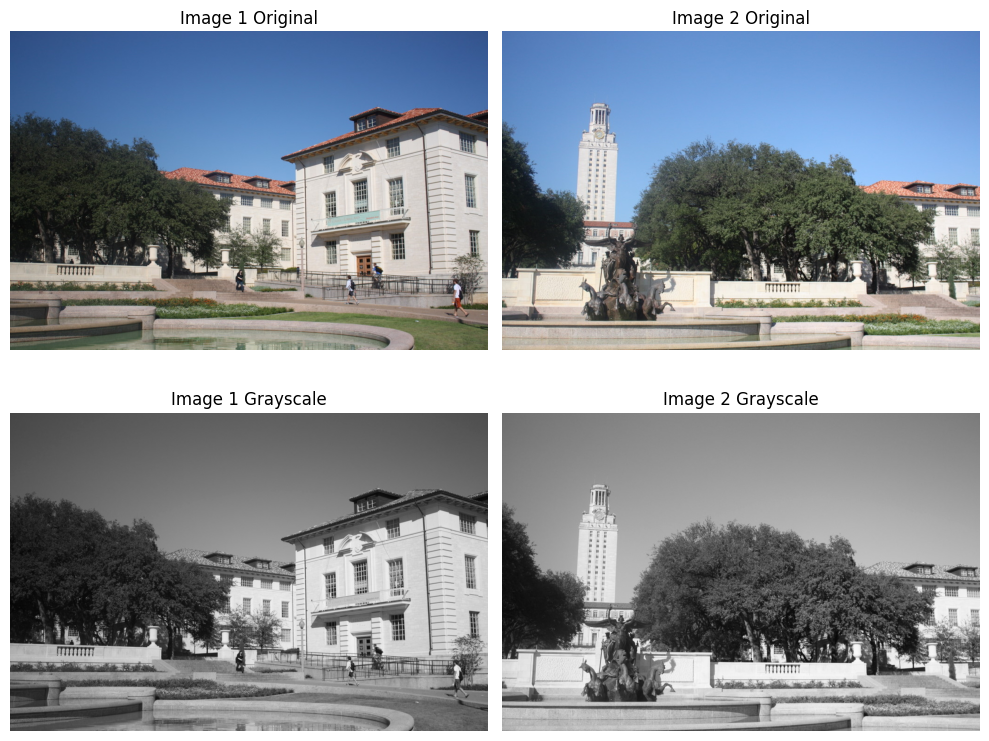

In [810]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Reading images
img1 = cv2.imread('materials/pano_image1.jpg')
img2 = cv2.imread('materials/pano_image2.jpg')

# Converting to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Convert BGR to RGB for matplotlib display
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Plot original and grayscale next to each other
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].imshow(img1_rgb)
axs[0, 0].set_title("Image 1 Original")
axs[0, 0].axis('off')

axs[0, 1].imshow(img2_rgb)
axs[0, 1].set_title("Image 2 Original")
axs[0, 1].axis('off')

axs[1, 0].imshow(gray1, cmap='gray')
axs[1, 0].set_title("Image 1 Grayscale")
axs[1, 0].axis('off')

axs[1, 1].imshow(gray2, cmap='gray')
axs[1, 1].set_title("Image 2 Grayscale")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

In this part, we will get correspondences between the two images using the sift descriptor. Then we are going to match the correspondences and filter them.

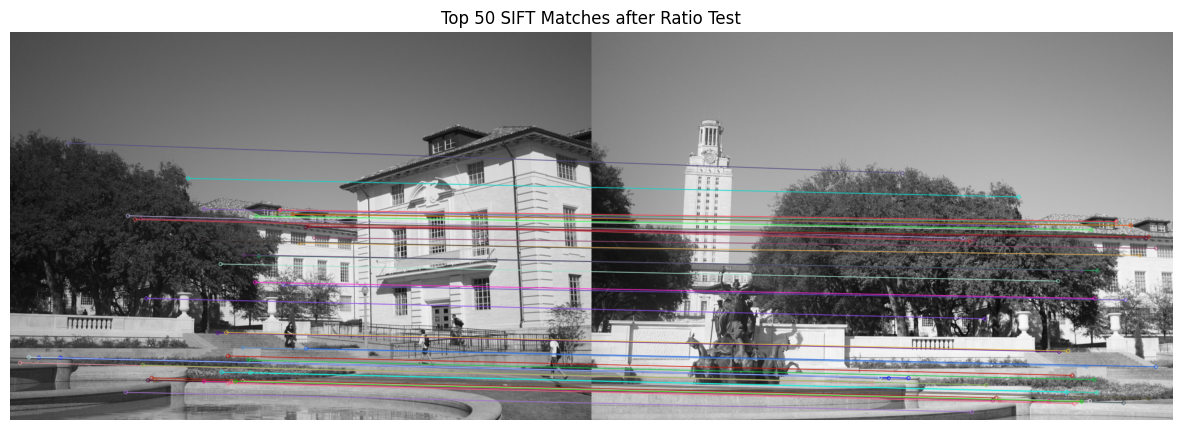

In [811]:
def get_correspondences(img1, img2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    # Select 50 best matches
    good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]

    return good_matches, kp1, kp2

good_matches, kp1,kp2 = get_correspondences(gray1, gray2)

matched_img = cv2.drawMatches(gray1, kp1, gray2, kp2, good_matches, None, flags=2) 
plt.figure(figsize=(15, 8))
plt.imshow(matched_img)
plt.title('Top 50 SIFT Matches after Ratio Test')
plt.axis('off')
plt.show()

Onto computing the homography now:
Using every set of matching points, we append the correspondence to the matrix, and perform svd on the final matrix to obtain the parameters of the homography.

Ransac implementation for computing homography:
We choose 4 random points and compute the homography matrix many times, and we use the matrix which results in the highest number of inliers(measured against a threshold for error).

In [812]:
# Get the coordinates of the points in both images
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# Compute Homography using our function
def compute_homography(pts1, pts2):
    A = []
    for (x1, y1), (x2, y2) in zip(pts1, pts2):
        A.append([-x1, -y1, -1, 0, 0, 0, x2 * x1, x2 * y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2 * x1, y2 * y1, y2])
    A = np.array(A)
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    return H / H[2, 2]

# RANSAC implementation
def ransac_homography(pts1, pts2, iterations=15000, threshold=4.0):
    best_H = None
    max_inliers = 0
    for _ in range(iterations):
        # Randomly select 4 point correspondences (min needed for H)
        indices = np.random.choice(len(pts1), 4, replace=False)
        sampled_pts1 = pts1[indices]
        sampled_pts2 = pts2[indices]

        # Compute homography for the sampled points
        H = compute_homography(sampled_pts1, sampled_pts2)

        # Count inliers
        inliers = 0
        for (x1, y1), (x2, y2) in zip(pts1, pts2):
            projected = np.dot(H, [x1, y1, 1])
            projected /= projected[2]  # Normalize
            error = np.linalg.norm(projected[:2] - [x2, y2])
            if error < threshold:
                inliers += 1

        # Update best model
        if inliers > max_inliers:
            max_inliers = inliers
            best_H = H

    return best_H

# Apply RANSAC
H = ransac_homography(pts1, pts2)

Normalizing Intensities:
We will write a function that normalizes the intensity of one image to match that of another image using keypoints and descriptors.

We iterate over keypoints, and get a path of a set size around the keypoint, then we calculate the adjustment factor needed by dividing the intensities, and normalize one image to the other.

In [813]:
def normalize_intensity_with_keypoints(img1, img2, keypoints1, keypoints2, matches):
    patch_size = 5  # Size of neighborhood around keypoints
    intensities1 = []
    intensities2 = []

    for match in matches:
        # Extract coordinates of matched keypoints
        kp1 = keypoints1[match.queryIdx].pt
        kp2 = keypoints2[match.trainIdx].pt
        x1, y1 = int(kp1[0]), int(kp1[1])
        x2, y2 = int(kp2[0]), int(kp2[1])

        # Ensure coordinates are within image bounds
        if (y1 > patch_size and y1 < img1.shape[0] - patch_size and
            x1 > patch_size and x1 < img1.shape[1] - patch_size and
            y2 > patch_size and y2 < img2.shape[0] - patch_size and
            x2 > patch_size and x2 < img2.shape[1] - patch_size):
            
            # Extract patch intensities around keypoints
            patch1 = img1[y1 - patch_size:y1 + patch_size, x1 - patch_size:x1 + patch_size]
            patch2 = img2[y2 - patch_size:y2 + patch_size, x2 - patch_size:x2 + patch_size]
            
            # Compute average intensity for the patches
            intensities1.append(np.mean(patch1))
            intensities2.append(np.mean(patch2))
    
    # Compute the global intensity adjustment factor
    if intensities1 and intensities2:
        adjustment_factor = np.mean(intensities2) / np.mean(intensities1)
        img1_normalized = np.clip(img1 * adjustment_factor, 0, 255).astype(np.uint8)
        return img1_normalized
    else:
        # Fallback if no matches or adjustment possible
        print("No sufficient matches to compute intensity normalization.")
        return img1

# Apply intensity normalization
img1_normalized = normalize_intensity_with_keypoints(img1, img2, kp1, kp2, good_matches)

The inverse warp function:
1. Extracting input image shape and setting the output canvas shape
2. Placing img2 at the center of the canvas
3. Create a mask for img2 pixels, so that img1 pixels aren't warped to it, and adjusting H to account for offset
4. Calculate H inverse using numpy
5. Building matrix for positions of pixels in output image, then applying inverse homography to obtain source coordinates for each pixel
6. Dividing by the Z component of each pixel to normalize
7. Performing interpolation over 3 channels of colour to obtain warped image
8. Use the crop_to_content helper function to remove unwanted black regions

In [814]:
def crop_to_content(image):
    # Convert the image to grayscale to detect non-black areas
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find the non-black pixel coordinates
    non_black_coords = cv2.findNonZero(gray)

    if non_black_coords is not None:
        # Compute the bounding rectangle for non-black pixels
        x, y, w, h = cv2.boundingRect(non_black_coords)
        
        # Crop the image to this rectangle
        cropped_image = image[y:y+h, x:x+w]
        return cropped_image
    else:
        # Return the original image if no non-black pixels are found
        return image


def warp_image_with_mask(img1, img2, H):
    # compute output canvas dimensions as 2.5 x img1 size
    img1_h, img1_w = img1.shape[:2]
    output_h = int(img1_h * 2.5)
    output_w = int(img1_w * 2.5)
    canvas = np.zeros((output_h, output_w, 3), dtype=np.uint8)

    # Placing img2 at the center of the canvas
    img2_h, img2_w = img2.shape[:2]
    center_y = (output_h - img2_h) // 2
    center_x = (output_w - img2_w) // 2
    canvas[center_y:center_y + img2_h, center_x:center_x + img2_w] = img2

    # Create a mask for img2's regions on the canvas
    mask = np.zeros((output_h, output_w), dtype=np.uint8)
    mask[center_y:center_y + img2_h, center_x:center_x + img2_w] = 255

    # Offset the homography matrix to account for the placement of img2
    offset = np.array([
        [1, 0, center_x],
        [0, 1, center_y],
        [0, 0, 1]
    ])
    H_adjusted = offset @ H  # Adjust homography to align img1 properly

    # Warp img1 onto the canvas
    H_inv = np.linalg.inv(H_adjusted)
    x_out, y_out = np.meshgrid(np.arange(output_w), np.arange(output_h))
    ones = np.ones_like(x_out)
    coords = np.stack([x_out, y_out, ones], axis=-1).reshape(-1, 3).T  # shape: (3, N)

    src_coords = H_inv @ coords
    src_coords /= src_coords[2, :]  # Normalize

    x_src = src_coords[0, :].reshape(output_h, output_w)
    y_src = src_coords[1, :].reshape(output_h, output_w)

    warped_img = np.zeros((output_h, output_w, 3), dtype=np.uint8)

    for c in range(3):  # RGB channels
        warped_channel = cv2.remap(img1[..., c], x_src.astype(np.float32), y_src.astype(np.float32),
                                   interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
        warped_img[..., c] = np.where(warped_channel > 0, warped_channel, warped_img[..., c])

    # Merge warped_img onto canvas using the mask
    for c in range(3):
        canvas[..., c] = np.where(mask == 0, warped_img[..., c], canvas[..., c])

    canvas = crop_to_content(canvas) # remove unnecessary black regions
    return canvas

Building the mosiac using the developed function, then displaying it

In [815]:
result = warp_image_with_mask(img1_normalized, img2, H)
cv2.imshow("First Mosaic", result)
cv2.imwrite("mosaic_result.jpg", result)

True

Displaying the output

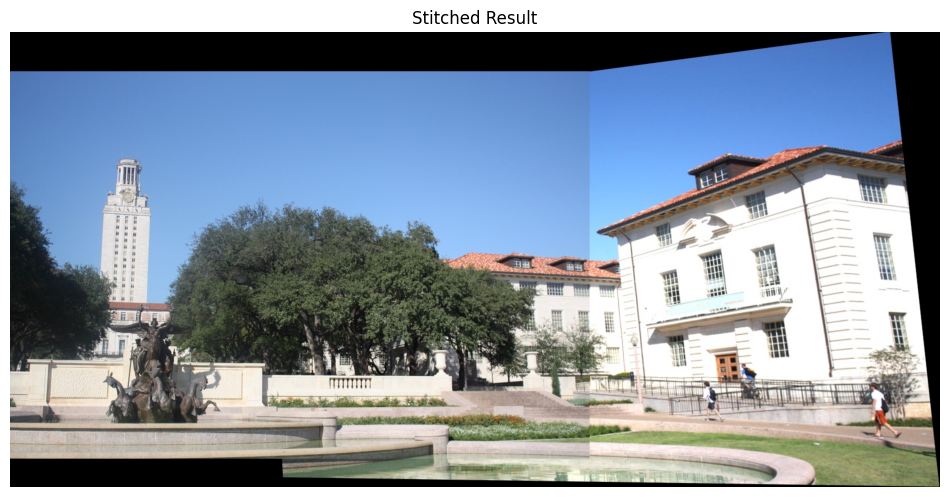

In [816]:
img = cv2.imread('mosaic_result.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.title("Stitched Result")
plt.axis('off')
plt.show()

# Onto the bonus part: a mosiac of 3 images

This part will not introduce anything new, just using the functions already developed over two stages

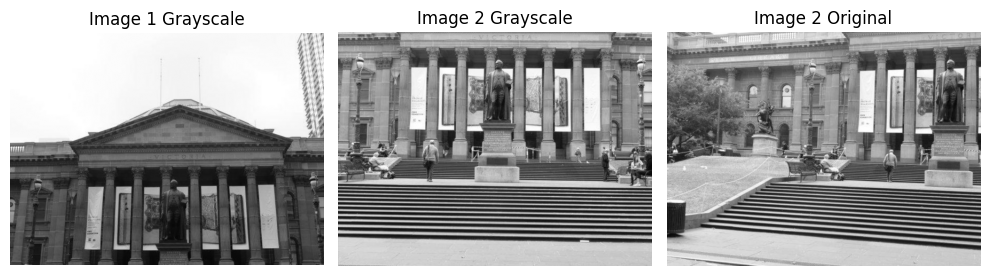

In [817]:
# Let's see our input images for this mosiac
img1 = cv2.imread('materials/v1.png')
img2 = cv2.imread('materials/v2.png')
img3 = cv2.imread('materials/v3.png')

# Converting to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
gray3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)


# Plot original and grayscale next to each other
fig, axs = plt.subplots(1, 3, figsize=(10, 8))

axs[0].imshow(gray1, cmap='gray')
axs[0].set_title("Image 1 Grayscale")
axs[0].axis('off')

axs[1].imshow(gray2, cmap='gray')
axs[1].set_title("Image 2 Grayscale")
axs[1].axis('off')

axs[2].imshow(gray3, cmap='gray')
axs[2].set_title("Image 2 Original")
axs[2].axis('off')

plt.tight_layout()
plt.show()

Now onto getting correspondences between first two pictures and getting the homography function.

In [818]:
good_matches, kp1,kp2 = get_correspondences(gray1, gray2)

pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

H12 = ransac_homography(pts1, pts2) # Homography from img1 to img2
img1_normalized = normalize_intensity_with_keypoints(img1, img2, kp1, kp2, good_matches)

Let's build the mosiac of the first two points

In [819]:
warped_img1 = warp_image_with_mask(img1_normalized, img2, H12)
cv2.imshow("Intermediary Mosaic", warped_img1)
cv2.imwrite("intermediate_stitched_result.jpg", warped_img1)

True

Let's check it

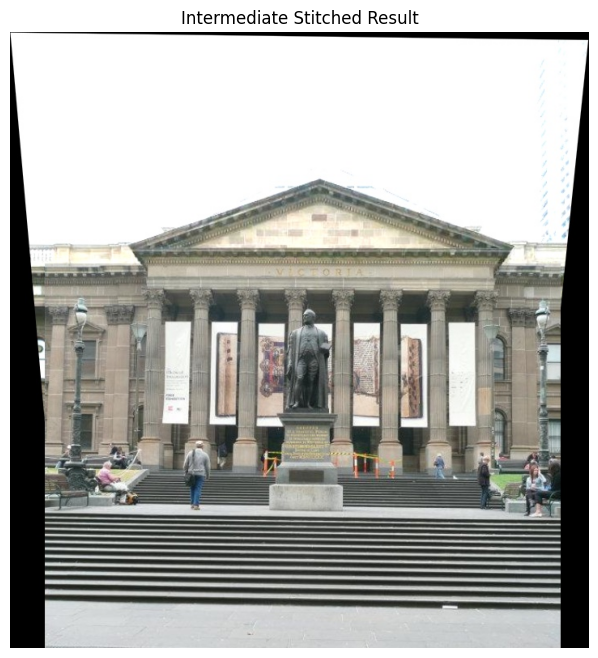

In [820]:
img12 = cv2.imread('intermediate_stitched_result.jpg')
gray12= cv2.cvtColor(img12, cv2.COLOR_BGR2GRAY)
img12_rgb = cv2.cvtColor(img12, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(img12_rgb)
plt.title("Intermediate Stitched Result")
plt.axis('off')
plt.show()

We will repeat all the previous steps again between that stitched image and image 3

In [821]:
good_matches, kp1,kp2 = get_correspondences(gray12, gray3)

pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

img12_normalized = normalize_intensity_with_keypoints(img12, img3, kp1, kp2, good_matches)
H123 = ransac_homography(pts1, pts2) # Homography from img3 to the mosiac

Building the final mosiac of 3

In [822]:
warped_img2 = warp_image_with_mask(img12_normalized, img3 ,H123)
cv2.imshow("Final Mosaic", warped_img2)
cv2.imwrite("tertiary_stitched_result.jpg", warped_img2)

True

Display

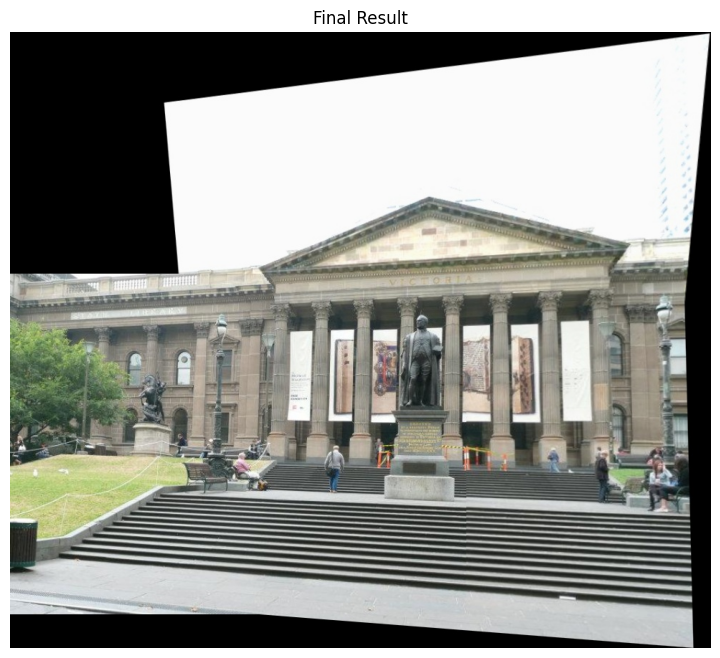

In [823]:
img123 = cv2.imread('tertiary_stitched_result.jpg')
img123_rgb = cv2.cvtColor(img123, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(img123_rgb)
plt.title("Final Result")
plt.axis('off')
plt.show()